# Garbage Classification (Machine Learning only)
- Feature extraction: Bag of Word + Color Histogram
- Data Augmentation
- Dimensionality reduction: PCA


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

#### Load dataset

In [2]:
W, H = IMG_SIZE = (128, 128)

DATASET_PATH = "/mnt/c/Users/PC/PycharmProjects/garbage_classification/garbage-dataset"

#Lấy danh sách tất cả các folder
classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Classes found:", classes)

X_images, y_labels = [], []

for label in tqdm(classes, desc="Loading dataset"):
    folder = os.path.join(DATASET_PATH, label)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        #Đọc ảnh
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        #Chuẩn hóa ảnh về dạng BGR 3 kênh
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        X_images.append(img)
        y_labels.append(label)

X_images = np.array(X_images, dtype=np.uint8)
y_labels = np.array(y_labels)
print("Loaded:", X_images.shape, y_labels.shape)

Classes found: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


Loading dataset: 100%|██████████| 10/10 [02:15<00:00, 13.59s/it]


Loaded: (19762, 128, 128, 3) (19762,)


##### Distribution

/tmp/ipykernel_17872/1708090181.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=unique, y=counts, palette="viridis")


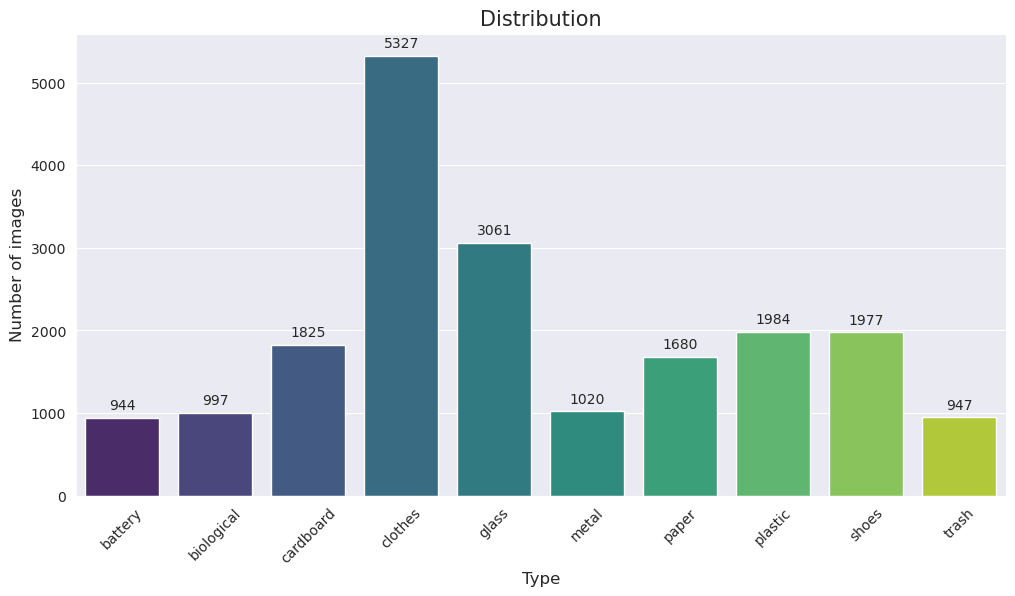

In [3]:
def plot_distribution(y):
    plt.figure(figsize=(12, 6))

    unique, counts = np.unique(y, return_counts=True)

    ax = sns.barplot(x=unique, y=counts, palette="viridis")

    plt.title("Distribution", fontsize=15)
    plt.xlabel("Type", fontsize=12)
    plt.ylabel("Number of images", fontsize=12)
    plt.xticks(rotation=45)

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')
    plt.show()

plot_distribution(y_labels)

#### Train/Test split

In [4]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_images, y_labels, test_size=0.2, stratify=y_labels, random_state=42
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

Train: (15809, 128, 128, 3) Test: (3953, 128, 128, 3)


#### Data augmentation

In [5]:
def augment_image(img):
    img = cv2.resize(img, IMG_SIZE)
    if np.random.rand() > 0.5:
        img = cv2.flip(img, 1)
    angle = np.random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((W//2, H//2), angle, 1)
    img = cv2.warpAffine(img, M, (W, H))
    factor = 0.7 + np.random.rand() * 0.6
    img = np.clip(img.astype(np.float32) * factor, 0, 255).astype(np.uint8)
    return img

X_train_aug = []
y_train_aug = []

for img, label in zip(X_train_raw, y_train_raw):
    X_train_aug.append(img)
    y_train_aug.append(label)
    for _ in range(2):
        #Tạo 2 ảnh tăng cường cho mỗi ảnh gốc nhưng vẫn giữ nguyên nhãn
        X_train_aug.append(augment_image(img))
        y_train_aug.append(label)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)
print("Train after augmentation:", X_train_aug.shape, y_train_aug.shape)

Train after augmentation: (47427, 128, 128, 3) (47427,)


#### Feature extraction

In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder

VOCAB_SIZE = 700

orb = cv2.ORB_create(nfeatures=700)
descriptors_list = []

for img in tqdm(X_train_aug, desc="ORB Detect (Train)"):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect
    kp, des = orb.detectAndCompute(gray, None)
    if des is not None:
        descriptors_list.append(des)

#Kiểm tra nếu không tìm thấy đặc trưng nào
if len(descriptors_list) == 0:
    raise ValueError("Error")

#Gộp tất cả descriptors lại thành 1 ma trận lớn
all_descriptors = np.vstack(descriptors_list)
print(f"Total descriptors found: {all_descriptors.shape}")

#CLUSTERING (MINIBATCH K-MEANS)
kmeans = MiniBatchKMeans(
    n_clusters=VOCAB_SIZE,
    batch_size=2048,
    random_state=42,
    n_init='auto'
)
kmeans.fit(all_descriptors)
print("Vocabulary built successfully.")

#BoW + COLOR HISTOGRAM
def extract_features_bow(img, kmeans_model):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = orb.detectAndCompute(gray, None)

    bow_hist = np.zeros(VOCAB_SIZE, dtype=np.float32)

    if des is not None:
        #Dự đoán xem mỗi descriptor thuộc cụm từ vựng nào
        preds = kmeans_model.predict(des)
        # Đếm tần suất
        unique, counts = np.unique(preds, return_counts=True)
        for u, c in zip(unique, counts):
            bow_hist[u] = c

    #Chuẩn hóa L2 cho BoW
    bow_hist = cv2.normalize(bow_hist.reshape(1, -1), None, norm_type=cv2.NORM_L2).flatten()

    #Color Histogram
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_hist = cv2.calcHist([hsv], [0], None, [16], [0, 180]).flatten()
    s_hist = cv2.calcHist([hsv], [1], None, [16], [0, 256]).flatten()
    v_hist = cv2.calcHist([hsv], [2], None, [16], [0, 256]).flatten()

    # Ghép và Chuẩn hóa L2 cho Màu
    color_feat = np.concatenate([h_hist, s_hist, v_hist])
    color_feat = cv2.normalize(color_feat.reshape(1, -1), None, norm_type=cv2.NORM_L2).flatten()

    #Kết hợp cả hai
    return np.concatenate([bow_hist, color_feat])

#TRÍCH XUẤT CHO TRAIN VÀ TEST
X_train_feats = []
for img in tqdm(X_train_aug, desc="Extract Train"):
    X_train_feats.append(extract_features_bow(img, kmeans))
X_train_feats = np.array(X_train_feats, dtype=np.float32)

X_test_feats = []
for img in tqdm(X_test_raw, desc="Extract Test"):
    X_test_feats.append(extract_features_bow(img, kmeans))
X_test_feats = np.array(X_test_feats, dtype=np.float32)

print("Features extracted:", X_train_feats.shape, X_test_feats.shape)

#LABEL ENCODING
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test_raw)
unique_classes, counts = np.unique(y_train_enc, return_counts=True)
class_names = le.inverse_transform(unique_classes)

ORB Detect (Train): 100%|██████████| 47427/47427 [00:19<00:00, 2442.57it/s]


Total descriptors found: (5986098, 32)
Vocabulary built successfully.


Extract Test: 100%|██████████| 3953/3953 [00:03<00:00, 1180.00it/s]

Features extracted: (47427, 748) (3953, 748)


##### Visualization after augmentation

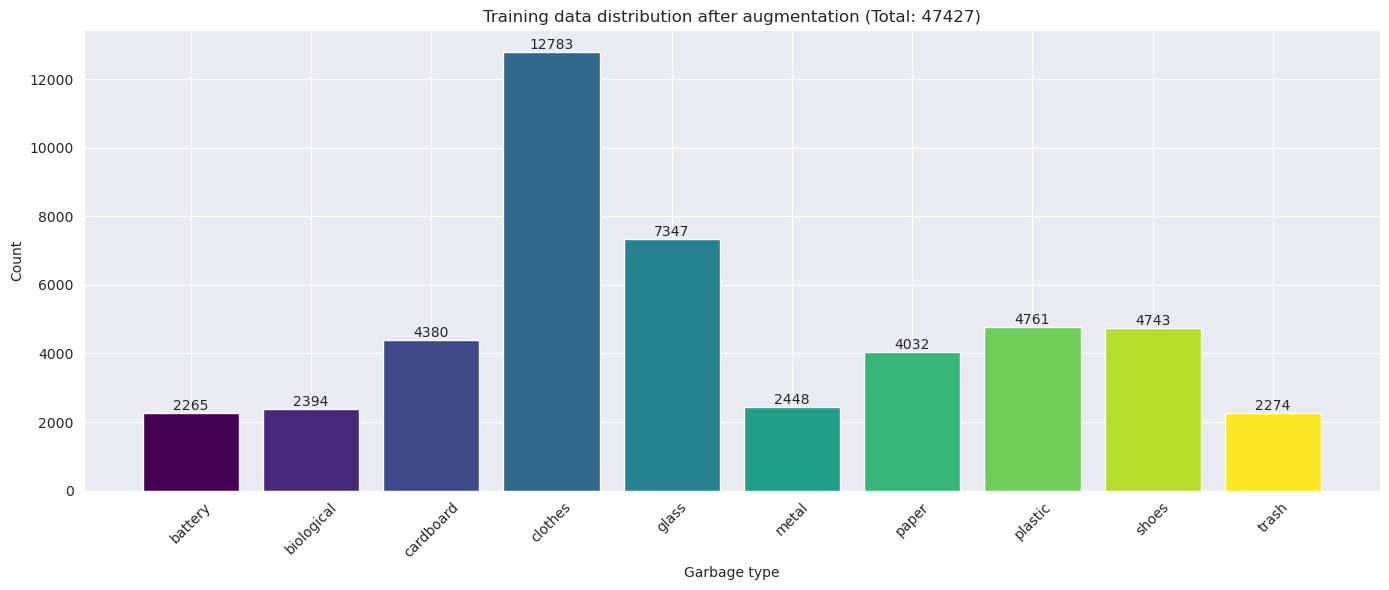

In [7]:
plt.figure(figsize=(14,6))
bars = plt.bar(class_names, counts, color=plt.cm.viridis(np.linspace(0,1,len(class_names))))
plt.title(f"Training data distribution after augmentation (Total: {len(y_train_enc)})")
plt.xlabel("Garbage type")
plt.ylabel("Count")
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height,
        s=f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.tight_layout()
plt.show()

#### Standalization & PCA

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feats)
X_test_scaled  = scaler.transform(X_test_feats)

pca = PCA(n_components=300, random_state=42)
print("Number of PCA components selected:", pca.n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

Number of PCA components selected: 300


#### Training model and Prediction & Evaluation

In [9]:
from sklearn.svm import SVC

model = SVC(
    kernel="rbf",
    C=5,
    gamma="scale",
    probability = False,
)

model.fit(X_train_pca, y_train_enc)

,C,5
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Prediction & Evaluation

Test Accuracy : 0.6021

Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.62      0.66       189
           1       0.56      0.60      0.58       199
           2       0.60      0.61      0.61       365
           3       0.68      0.84      0.75      1066
           4       0.58      0.62      0.60       612
           5       0.45      0.25      0.33       204
           6       0.53      0.53      0.53       336
           7       0.52      0.45      0.48       397
           8       0.55      0.43      0.48       396
           9       0.57      0.36      0.44       189

    accuracy                           0.60      3953
   macro avg       0.57      0.53      0.55      3953
weighted avg       0.59      0.60      0.59      3953



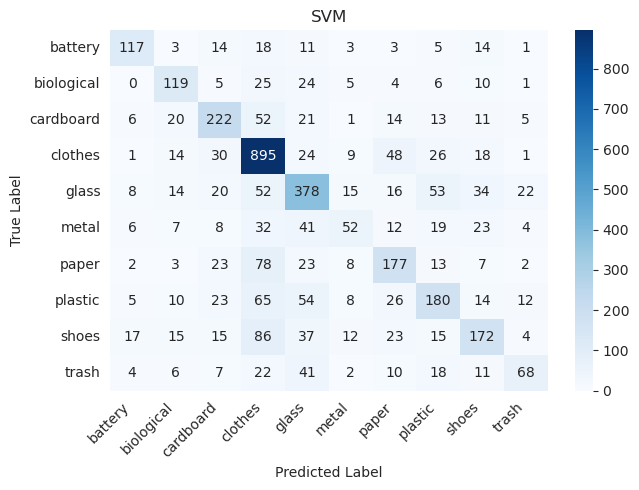

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Predict
y_test_pred  = model.predict(X_test_pca)

#Evaluation
test_acc  = accuracy_score(y_test_enc, y_test_pred)

print(f"Test Accuracy : {test_acc:.4f}\n")

classes = np.unique(y_train_enc)

print("Classification Report:\n")
print(classification_report(y_test_enc, y_test_pred, target_names=classes.astype(str)))

#Heatmap
class_names = [
    'battery',
    'biological',
    'cardboard',
    'clothes',
    'glass',
    'metal',
    'paper',
    'plastic',
    'shoes',
    'trash'
]

models = {
    "SVM": y_test_pred,
}

cmaps = {
    "SVM": "Blues",
}

plt.figure(figsize=(18, 5))

for i, (name, y_pred) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test_enc, y_pred)

    plt.subplot(1, 3, i)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmaps[name],
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f"{name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

#### Import

In [13]:
import joblib
joblib.dump(model, "svm_garbage_model.pkl")
joblib.dump(le, "le_garbage_model.pkl")
joblib.dump(kmeans, 'kmeans_garbage_model.pkl')
joblib.dump(scaler, 'scaler_garbage_model.pkl')
joblib.dump(pca, 'pca_garbage_model.pkl')

['pca_garbage_model.pkl']